# Imports

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Introducion:

There will be two sections in this notebook. The first portion [Iteration 1](#Iteration_1) datasets, The first is [01_sub_reddit_data](../Data/01_sub_reddit_data.csv) which contained an inital 3992 records; however upon our first analysis, we found that nearly 70% of our titles were removed by a moderator. We assume that removed post violate the subreddit guidelines which wont be representive of the subreddits.

We then went back to the data collection notebook [01_data_collecting](../Code/01_data_collecting.ipynb) and added parameters to pull post that had a minimum of 4 post and was not removed by a moderator; however, the removed by moderator parameter was depercated. Then we proceeded to clean the data of the new column in [Iteration 1](#Iteration_2). We decided against concatenating the clean data to the new list, because we didnt want to cause issues with our feature engineered columns causing a punch of NULL or blank columns to appear in the new data set.

# Iteration 1

## Load Data

In [2]:
df = pd.read_csv('../Data/01_sub_reddits_data.csv')
df.head(1)

,subreddit,selftext,author_fullname,gilded,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,...,num_crossposts,media,is_video,retrieved_utc,updated_utc,utc_datetime_str,post_hint,preview,link_flair_template_id,author_cakeday
0,AskWomen,[removed],t2_v4u69ho5,0,How about true friendship between men and wome...,[],r/AskWomen,False,6,NaN,...,0,NaN,False,1682375081,1682375081,2023-04-24 22:24:26,NaN,NaN,NaN,NaN


## Clean and select features

This portion is where we will select our inital features. As we clean our data we will continue to add additional features.

The inital features we selected were
1) Subreddit name
2) Title of the post
3) If the post has been hidden
4) The time Stamp
5) The number of comments

In [3]:
df.columns.sort_values()

Index(['all_awardings', 'allow_live_comments', 'archived', 'author',
       'author_cakeday', 'author_flair_background_color',
       'author_flair_css_class', 'author_flair_richtext',
       'author_flair_template_id', 'author_flair_text',
       'author_flair_text_color', 'author_flair_type', 'author_fullname',
       'author_patreon_flair', 'author_premium', 'awarders', 'can_gild',
       'category', 'content_categories', 'contest_mode', 'created_utc',
       'discussion_type', 'distinguished', 'domain', 'edited', 'gilded',
       'gildings', 'hidden', 'hide_score', 'id', 'is_created_from_ads_ui',
       'is_crosspostable', 'is_meta', 'is_original_content',
       'is_reddit_media_domain', 'is_robot_indexable', 'is_self', 'is_video',
       'link_flair_background_color', 'link_flair_css_class',
       'link_flair_richtext', 'link_flair_template_id', 'link_flair_text',
       'link_flair_text_color', 'link_flair_type', 'locked', 'media',
       'media_embed', 'media_only', 'no_follow

In [4]:
clean_df=df[['id', 'subreddit','title', 'utc_datetime_str', 'hidden', 'num_comments']]

In [5]:
#set an index that we can reference if needed
clean_df.set_index('id', inplace=True)
df.set_index('id', inplace=True)

In [6]:
clean_df.head(3)

,subreddit,title,utc_datetime_str,hidden,num_comments
id,,,,,
12xyt9k,AskWomen,How about true friendship between men and wome...,2023-04-24 22:24:26,False,0
12xymt1,AskWomen,Does this mean she’s not interested? What shou...,2023-04-24 22:18:10,False,1
12xylur,AskWomen,What’s something that your brain cannot compre...,2023-04-24 22:17:10,False,0


## Feature engineering

### Creating a date column
This portion is used to get the date of a post, and identify what day of the week of a post

In [7]:
#convert the utc_datetime_str into a date time data type
clean_df.loc[:, 'utc_datetime_str']= pd.to_datetime(clean_df.loc[:, 'utc_datetime_str'])

C:\Users\Derik\AppData\Local\Temp\ipykernel_20020\1726003547.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df.loc[:, 'utc_datetime_str']= pd.to_datetime(clean_df.loc[:, 'utc_datetime_str'])


In [8]:
clean_df.head(3)

,subreddit,title,utc_datetime_str,hidden,num_comments
id,,,,,
12xyt9k,AskWomen,How about true friendship between men and wome...,2023-04-24 22:24:26,False,0
12xymt1,AskWomen,Does this mean she’s not interested? What shou...,2023-04-24 22:18:10,False,1
12xylur,AskWomen,What’s something that your brain cannot compre...,2023-04-24 22:17:10,False,0


In [9]:
clean_df.dtypes

subreddit                   object
title                       object
utc_datetime_str    datetime64[ns]
hidden                        bool
num_comments                 int64
dtype: object

In [10]:
#referenced this stack overflow: https://stackoverflow.com/questions/28009370/get-weekday-day-of-week-for-datetime-column-of-dataframe
clean_df['day_name'] = clean_df['utc_datetime_str'].apply(lambda x: x.day_name())

C:\Users\Derik\AppData\Local\Temp\ipykernel_20020\229520572.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['day_name'] = clean_df['utc_datetime_str'].apply(lambda x: x.day_name())


In [11]:
clean_df.head(3)

,subreddit,title,utc_datetime_str,hidden,num_comments,day_name
id,,,,,,
12xyt9k,AskWomen,How about true friendship between men and wome...,2023-04-24 22:24:26,False,0,Monday
12xymt1,AskWomen,Does this mean she’s not interested? What shou...,2023-04-24 22:18:10,False,1,Monday
12xylur,AskWomen,What’s something that your brain cannot compre...,2023-04-24 22:17:10,False,0,Monday


### Creating a title word count column
This portion is used to check the word count of a title

In [12]:
clean_df['title_word_count'] = clean_df['title'].apply(lambda text: len(text.split()))

C:\Users\Derik\AppData\Local\Temp\ipykernel_20020\1397197032.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['title_word_count'] = clean_df['title'].apply(lambda text: len(text.split()))


In [13]:
#see distribution of word counts
clean_df['title_word_count'].value_counts(sort=True)

9     333
8     325
10    312
12    290
11    269
7     252
13    213
6     206
14    205
15    198
17    153
16    150
18    123
5     108
19    100
20     76
4      74
21     58
23     57
3      51
22     50
2      47
1      42
24     40
25     39
26     27
27     25
31     20
28     19
29     14
30     13
32     11
35      9
34      7
49      6
36      6
39      5
33      5
52      5
37      4
44      4
42      3
38      3
47      3
56      3
41      3
59      3
54      3
43      3
53      2
51      2
40      2
45      2
50      2
46      2
48      1
62      1
58      1
63      1
60      1
Name: title_word_count, dtype: int64

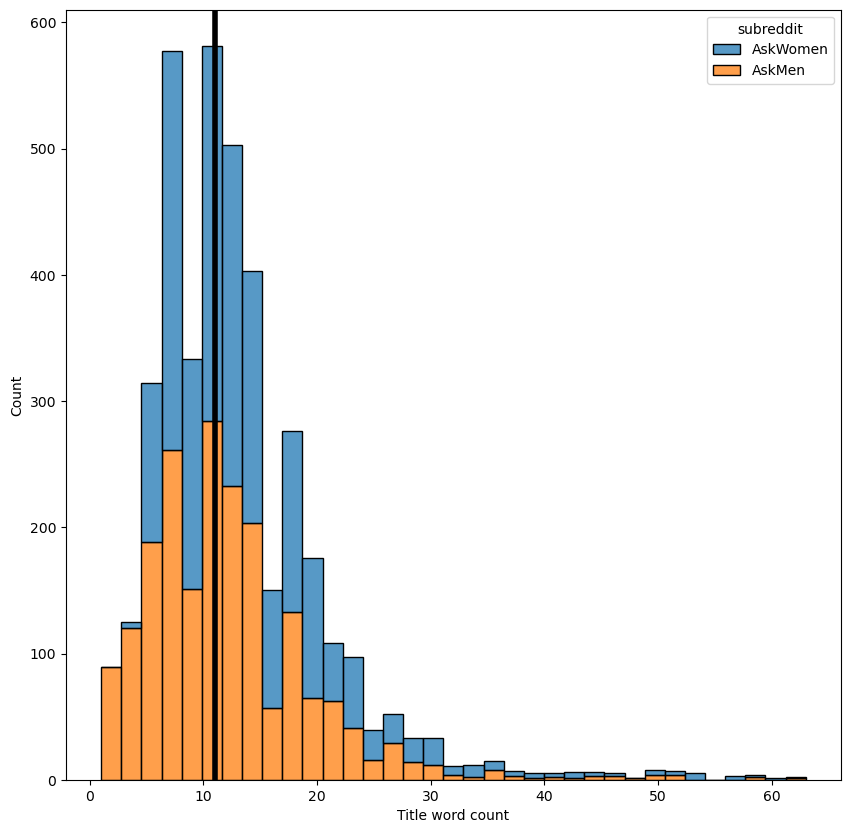

In [14]:
plt.figure(figsize=(10,10))
sns.histplot(data= clean_df, multiple ="stack", x = 'title_word_count', hue='subreddit', bins=35)
plt.axvline(x=clean_df['title_word_count'].median(), color='black', linewidth=4)
plt.xlabel("Title word count");

It appears there are vastly more post in askwomen and the median words in titles 

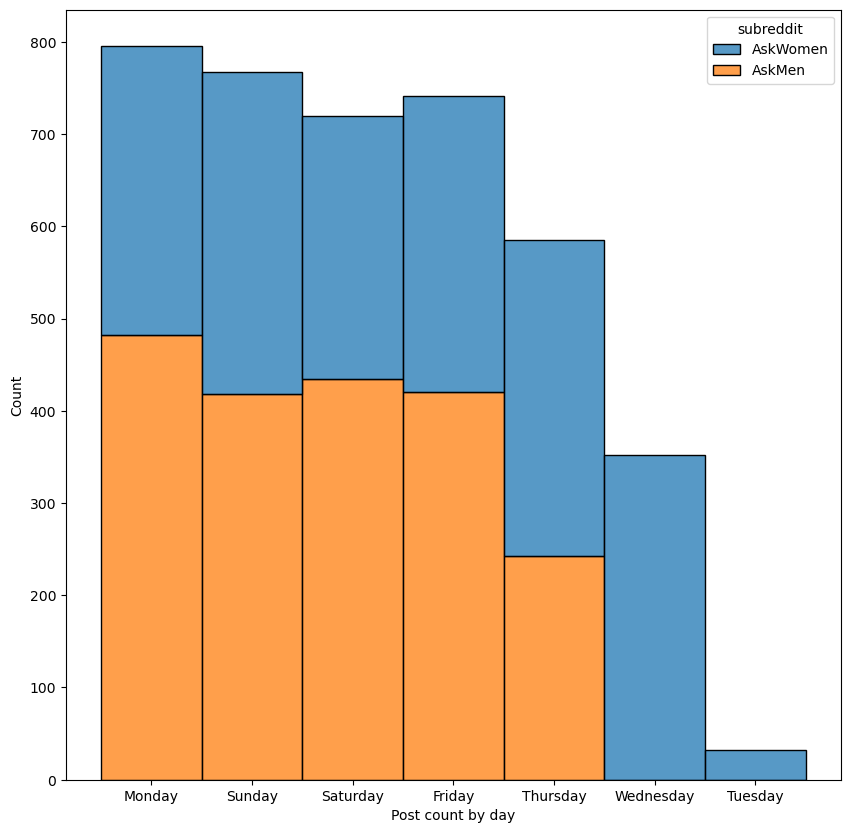

In [15]:
#Overview of post frequencies by day
plt.figure(figsize=(10,10))
sns.histplot(data= clean_df, multiple ="stack", x = 'day_name', hue='subreddit')
plt.xlabel("Post count by day");

It appears the frequency of post is significantly higher in AskWomen that it is in askmen. The days with the fewest post are from wednesday and tuesday.

### Sentiment analysis

In [16]:
sent = SentimentIntensityAnalyzer()

In [17]:
#test to see the output of the analyzer
sent.polarity_scores(clean_df['title'][0])

{'neg': 0.0, 'neu': 0.584, 'pos': 0.416, 'compound': 0.6908}

In [18]:
#testing to see how to index the dictionary
sent.polarity_scores(clean_df['title'][0])['neu']

0.584

In [19]:
#splitting scores into columns
clean_df['negative_score'] = [sent.polarity_scores(clean_df['title'][i])['neg'] for i in range(len(clean_df['title']))]
clean_df['neutral_score'] = [sent.polarity_scores(clean_df['title'][i])['neu'] for i in range(len(clean_df['title']))]
clean_df['positive_score'] = [sent.polarity_scores(clean_df['title'][i])['pos'] for i in range(len(clean_df['title']))]
clean_df['compound_score'] = [sent.polarity_scores(clean_df['title'][i])['compound'] for i in range(len(clean_df['title']))]

C:\Users\Derik\AppData\Local\Temp\ipykernel_20020\2725373906.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['negative_score'] = [sent.polarity_scores(clean_df['title'][i])['neg'] for i in range(len(clean_df['title']))]
C:\Users\Derik\AppData\Local\Temp\ipykernel_20020\2725373906.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['neutral_score'] = [sent.polarity_scores(clean_df['title'][i])['neu'] for i in range(len(clean_df['title']))]
C:\Users\Derik\AppData\Local\Temp\ipykernel_200

In [20]:
clean_df.head(5)

,subreddit,title,utc_datetime_str,hidden,num_comments,day_name,title_word_count,negative_score,neutral_score,positive_score,compound_score
id,,,,,,,,,,,
12xyt9k,AskWomen,How about true friendship between men and wome...,2023-04-24 22:24:26,False,0,Monday,10,0.000,0.584,0.416,0.6908
12xymt1,AskWomen,Does this mean she’s not interested? What shou...,2023-04-24 22:18:10,False,1,Monday,10,0.247,0.753,0.000,-0.3855
12xylur,AskWomen,What’s something that your brain cannot compre...,2023-04-24 22:17:10,False,0,Monday,12,0.000,1.000,0.000,0.0000
12xylln,AskWomen,Does this mean she’s not interested? What shou...,2023-04-24 22:16:55,False,1,Monday,10,0.247,0.753,0.000,-0.3855
12xy4mb,AskWomen,"Out of curiosity, what are reasons TO have chi...",2023-04-24 22:00:29,False,1,Monday,9,0.000,1.000,0.000,0.0000


### Checking the 'hidden' column
This portion is to check to see if a post has been hidden

In [21]:
#check the hidden column
clean_df['hidden'].value_counts()

False    3992
Name: hidden, dtype: int64

In [22]:
#removed the hidden column since there are only false values
clean_df.drop(columns = 'hidden', inplace=True)

C:\Users\Derik\AppData\Local\Temp\ipykernel_20020\1289743119.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df.drop(columns = 'hidden', inplace=True)


Since none of the post in the dataset are hidden, I decided to just remove this feature because it doesnt differentiate our subreddits. 

### Checking the num_comments column
This portion is used to check how many comments are in each post.

In [23]:
'''
I had assumed num_comments was the number of comments within a thread, but thought the valuecounts was weird,
so when I looked at the api documentation it didnt specific what it was.
The Api documentation just states that num_comments is an integer between 1 and 500.

Will need to see how many post have been removed as well because that indicates a post was removed before
people could respond.
'''
clean_df['num_comments'].value_counts()

1    2300
0    1691
3       1
Name: num_comments, dtype: int64

________________________________________________________________________________
### Checking the removed column
This portion is used to check if a significant number of our post were removed

In [24]:
#check percent of post removed, df is the entire dataset without filtering
df['removed_by_category'].value_counts() / len(df)

moderator           0.666333
automod_filtered    0.047595
deleted             0.018537
reddit              0.015030
Name: removed_by_category, dtype: float64

Here is appears about 70% of post have been removed. I will now create a feature for our dataframe to determine if a post has been removed.

In [25]:
#check to see first few, here we see a nan, so we assume its not removed
df['removed_by_category'].head(5)

id
12xyt9k    automod_filtered
12xymt1           moderator
12xylur                 NaN
12xylln           moderator
12xy4mb           moderator
Name: removed_by_category, dtype: object

In [26]:
#check to see if the true/false match
df['removed_by_category'].notnull().head(5).astype(int)

id
12xyt9k    1
12xymt1    1
12xylur    0
12xylln    1
12xy4mb    1
Name: removed_by_category, dtype: int32

In [27]:
#NaNs indicate that a post was not removed,
clean_df['is_removed'] = df['removed_by_category'].notnull().astype(int)

C:\Users\Derik\AppData\Local\Temp\ipykernel_20020\3374793744.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['is_removed'] = df['removed_by_category'].notnull().astype(int)


In [28]:
clean_df['is_removed'].value_counts(normalize=True)

1    0.747495
0    0.252505
Name: is_removed, dtype: float64

Close to 75% of our data has been removed. Which is intresting. I wonder what type of questions get removed and which subreddit is more "heavily" moderated. With a high numer of removed post, it makes sense for the low number of comments, but it still feels low.

In [29]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3992 entries, 12xyt9k to 12szogj
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   subreddit         3992 non-null   object        
 1   title             3992 non-null   object        
 2   utc_datetime_str  3992 non-null   datetime64[ns]
 3   num_comments      3992 non-null   int64         
 4   day_name          3992 non-null   object        
 5   title_word_count  3992 non-null   int64         
 6   negative_score    3992 non-null   float64       
 7   neutral_score     3992 non-null   float64       
 8   positive_score    3992 non-null   float64       
 9   compound_score    3992 non-null   float64       
 10  is_removed        3992 non-null   int32         
dtypes: datetime64[ns](1), float64(4), int32(1), int64(2), object(3)
memory usage: 487.7+ KB


## Visualizing metrics

## Export cleaned data to a CSV

In [30]:
clean_df.head(1)

,subreddit,title,utc_datetime_str,num_comments,day_name,title_word_count,negative_score,neutral_score,positive_score,compound_score,is_removed
id,,,,,,,,,,,
12xyt9k,AskWomen,How about true friendship between men and wome...,2023-04-24 22:24:26,0,Monday,10,0.0,0.584,0.416,0.6908,1


In [31]:
clean_df.to_csv('../Data/sub_reddit_data_clean.csv')

## Vectorizing title data

In [32]:
#loading in data, so we dont have to run the entire notebook again
vect_df = pd.read_csv('../Data/sub_reddit_data_clean.csv')

In [33]:
vect_df.head(1)

,id,subreddit,title,utc_datetime_str,num_comments,day_name,title_word_count,negative_score,neutral_score,positive_score,compound_score,is_removed
0,12xyt9k,AskWomen,How about true friendship between men and wome...,2023-04-24 22:24:26,0,Monday,10,0.0,0.584,0.416,0.6908,1


In [34]:
cvec = CountVectorizer(stop_words='english')
X= vect_df['title']
X_cv = cvec.fit_transform(X)
X_cv.shape

(3992, 4600)

In [35]:
words_df = pd.DataFrame(X_cv.todense(), columns=cvec.get_feature_names_out())
words_df.head()

,0ft,10,100,1000,10k,11,12,120,13,15,...,youve,yr,yrs,zaralynn,zodiac,zone,вопросы,задавайте,миллионеров,сын
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
women_word = words_df[vect_df['subreddit'] == 'AskWomen'].sum().sort_values(ascending=False)

In [37]:
men_word = words_df[vect_df['subreddit'] == 'AskMen'].sum().sort_values(ascending=False)

_______________________________________________________

In [38]:
women_word.head(10)

women           314
did             155
men             120
feel            118
partner         116
like            112
man             109
does            101
relationship     98
guy              95
dtype: int64

## visualizing top 10 words

Text(0.5, 1.0, 'Top 10 words in AskWomen')

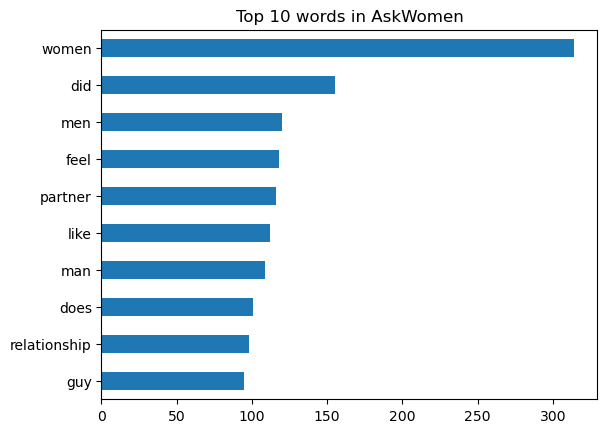

In [43]:
women_word.head(10).plot(kind ='barh').invert_yaxis()
plt.title('Top 10 words in AskWomen')

Here we see the top words in the AskWomen subreddit. Aside from nouns, it seems relationships is the most frequent topic in this subreddit.

In [40]:
men_word.head(10)

men             361
women           116
woman           115
guys            106
did             106
like             99
girl             84
relationship     82
man              74
think            73
dtype: int64

Text(0.5, 1.0, 'Top 10 words in Askmen')

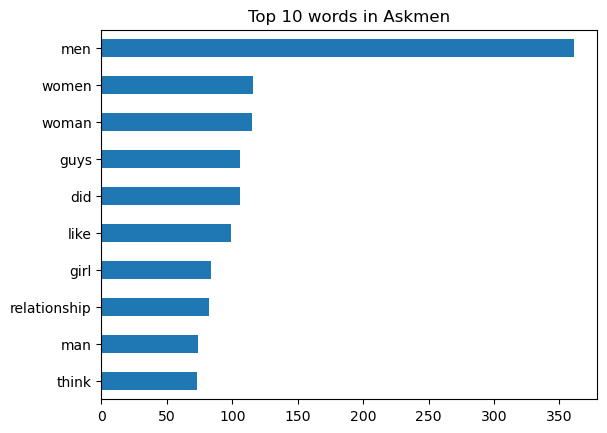

In [44]:
men_word.head(10).plot(kind ='barh').invert_yaxis()
plt.title('Top 10 words in Askmen')

It apears men, women, and woman appear freqently in both subreddits, so we can leave those features in when predicting what subreddit a post belongs to. Aside from those, it appears relationships is also a popular topic within this subreddit. However, it should be noted we only have about 2000 observations from each subreddit.

To convey this to stakeholders, we will create a side by side visualization of our word counts.

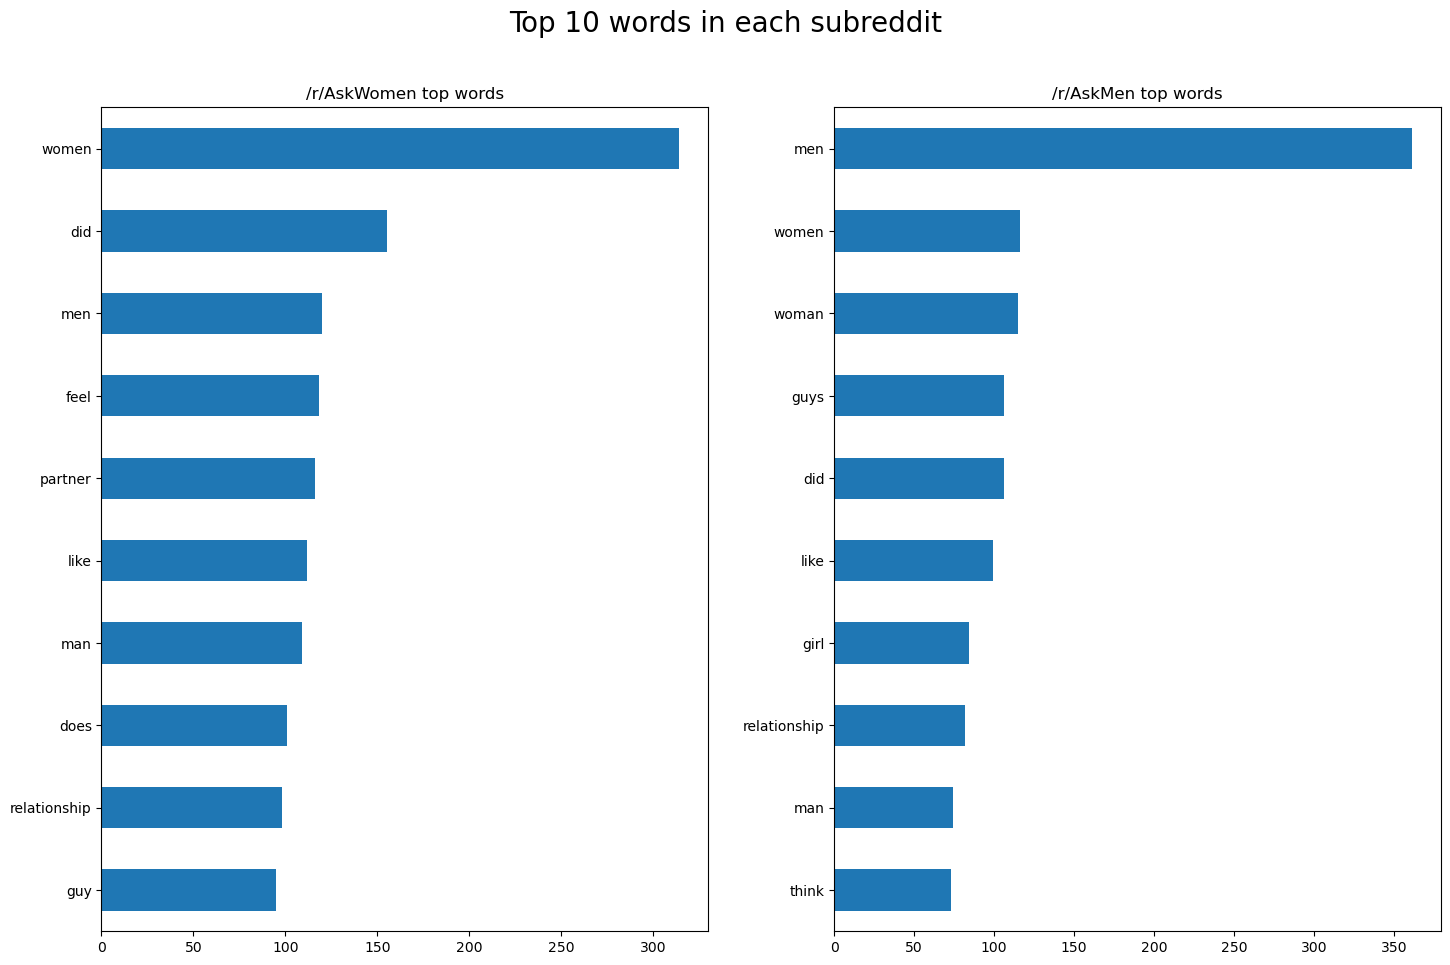

In [47]:
fig, a = plt.subplots(1,2, figsize=(15,10))
plt.suptitle('Top 10 words in each subreddit', fontsize= 20)
a[0].set_title('/r/AskWomen top words')
a[1].set_title('/r/AskMen top words')
women_word.head(10).plot(kind = 'barh', ax=a[0]).invert_yaxis()
men_word.head(10).plot(kind = 'barh', ax=a[1]).invert_yaxis()
fig.tight_layout(pad=2.5)

____________________________________________________________________________________
## Bigrams and Trigrams
To get a better sense of the words used in each respective subreddit, we will now create bigrams and trigrams of our titles to get a better sense of the topics and titles within each subreddit.


# Iteration 2

## Load data

In [10]:
df2 = pd.read_csv('../Data/02_sub_reddits_data.csv')
df2.head(1)

,subreddit,selftext,author_fullname,gilded,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,...,retrieved_utc,updated_utc,utc_datetime_str,post_hint,preview,author_cakeday,edited_on,author_created_utc,retrieved_on,link_flair_template_id
0,AskMen,NaN,t2_61gxv6mup,0,With two years left of college after this summ...,[],r/AskMen,False,6,NaN,...,1682377122,1682377123,2023-04-24 22:58:29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
